########################## LOADING TRAJECTORIES ##########################
normal
traj_5
(209520, 60)
traj_3
(449280, 60)
.ipynb_checkpoints
traj_4
(622080, 60)
traj_1
(786240, 60)
drug
traj_5
(853200, 60)
traj_8
(920160, 60)
traj_3
(959040, 60)
traj_4
(1026000, 60)
traj_7
(1092960, 60)
traj_2
(1159920, 60)
traj_6
(1226880, 60)
traj_1
(1293840, 60)
TRAJECTORY  30
########################## APPLY PCA ##########################


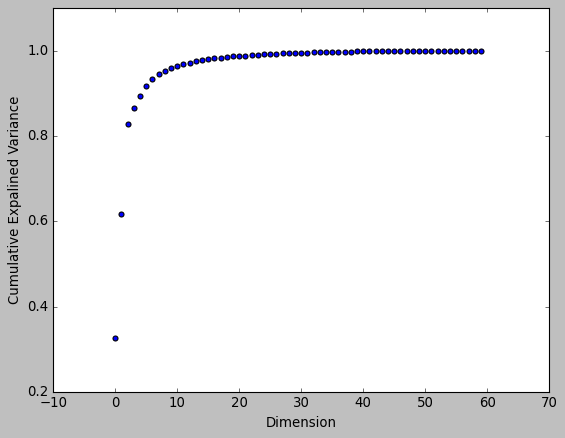

########################## CONTROL ANALYSIS ##########################


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math as mt
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')

from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE_
from scipy.spatial import distance
from scipy.stats import entropy
from mPE_ultis import integrand, ubble, array_list, permutation
from util import rolling_mean, probability, probability_v2, get_mPE_matrix
from sklearn.cluster import KMeans


# params:
n_PC = 2
significance_level = 0.01
decimals = 3

###################################################################################################################################################
################################################################ LOAD TRAJECTORIES ################################################################
###################################################################################################################################################

print('########################## LOADING TRAJECTORIES ##########################')

modes = ['normal', 'drug']
root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
# load entire high-dimensional trajectories
cnt = 0
lengths = []
for mode in modes:
    print(mode)
    trajs = os.listdir(root_dir + mode + '/' )
    for traj_n in trajs:
        print(traj_n)
        if traj_n != '.ipynb_checkpoints': 
            # loading entire high-dimensional trajectory
            path = root_dir + mode + '/' + traj_n + '/' + 'trajectories_na/'
            trajectories = os.listdir(path)
            # removing NaN columns
            nan_cols = []
            for i, time_bin in enumerate(trajectories):
                if time_bin != 'behavs' and time_bin != '.ipynb_checkpoints':
                    trajectory = loadmat(path + time_bin)
                    trajectory = trajectory['trajectory'] 
                    for i in range(trajectory.shape[1]):
                        if np.isnan(trajectory[:, i]).all():
                            nan_cols.append(i)

            # create trajectory
            nan_cols = np.asarray(nan_cols)
            a = 0
            sub_sampling = 50
            if nan_cols.size > 0:
                if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
                    sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]-len(nan_cols)) )
            else:
                sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]) )

            for i, time_bin in enumerate(trajectories):
                if time_bin != 'behavs':
                    trajectory = loadmat(path + time_bin)
                    trajectory = trajectory['trajectory'] 
                    if nan_cols.size > 0:
                        trajectory = np.delete(trajectory, nan_cols, 1)
                    
                    window = sub_sampling
                    mov_av_traj = rolling_mean(trajectory, window, overlapping=False)
                    idx_2 = i*mov_av_traj.shape[0]
                    sampled_trajectories[idx_2:idx_2+mov_av_traj.shape[0], 0:sampled_trajectories.shape[1]] = mov_av_traj
                    
            # convert nan to number when not it is a sparse recurrence (not an entire column)
            sampled_trajectories = np.nan_to_num(sampled_trajectories)
            lengths.append(sampled_trajectories.shape[0])

            # append trajectory to all trajectories
            if cnt==0:
                rats = sampled_trajectories
            if cnt>0:
                rats = np.concatenate((rats, sampled_trajectories), axis=0)
                
            cnt += 1

            print(rats.shape)

path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/data/rats.npy'
np.save(path_out, rats)
###################################################################################################################################################
####################################################################### PCA #######################################################################
###################################################################################################################################################

measures = []
# consists of:
# - explained variance
# - p-value (control)
# - j-s (control)
# - p-value(result)
# - j-s (result)

for which_traj, length in enumerate(lengths):
    print('TRAJECTORY ', str(i))
    # inspecting inter-dimensional variance with PCA
    if which_traj == 0:
        idx = 0
    else:
        idx += lengths[i-1]

    traj = rats[idx:idx+length, :]

    print('########################## APPLY PCA ##########################')

    pca = PCA()
    pca.fit(traj)

    explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]
    measures.append(sum(pca.explained_variance_ratio_[0:3]))

    plt.scatter(np.arange(traj.shape[1]), explained_var_plot)
    plt.ylabel('Cumulative Expalined Variance')
    plt.xlabel('Dimension')

    path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/' + str(n_PC) + 'PC/control/'
    name_out = mode + '_explained_var_' + 'traj_' + str(traj_n)

    plt.savefig(path_out +  name_out  + ".png")
    plt.show()

    # reduce data according to explained variance values using linear PCA
    pca = PCA(n_components=n_PC)
    reduced_traj = pca.fit_transform(traj)


    ###################################################################################################################################################
    ########################################################### CONTROL ANALYSIS ######################################################################
    ###################################################################################################################################################

    ########## Take random trajectories and check that they have approximately the same mPE ##########

    print('########################## CONTROL ANALYSIS ##########################')

    unit_length = 1500
    minutes = 60
    sub_fs = int(300/60)
    bin_length = sub_fs*60*minutes
    bins_number = 2
    traj_number = int(reduced_traj.shape[0]/2/unit_length)
    orders = [3]
    random = True

    too_low = True
    while too_low == True:

        mPE_vector = get_mPE_matrix(reduced_traj, bins_number, traj_number, orders, random)
        ########## plotting mPE continuous distribution as a function of time ##########
        fig = plt.figure()
        c = ['r', 'b']

        ax = sns.kdeplot(mPE_vector[0, :, 0], color=c[0])
        ax = sns.kdeplot(mPE_vector[1, :, 0], color=c[1])

        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Order 3 mPE (bits)')
        plt.ylabel('Estimated Density Function')

        path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/' + str(n_PC) + 'PC/control/'
        name_out = mode + '_control_' + 'traj_' + str(traj_n)

        plt.savefig(path_out +  name_out  + ".png")
        plt.show()

        ########## Retrieve maxiumum number of elements based on a raw decimal discretization ##########
        data = mPE_vector.flatten()
        kmeans = KMeans(n_clusters=20).fit(data.reshape(-1,1))
        kmeans.predict(data.reshape(-1,1))
        centroids = kmeans.cluster_centers_
        centroids = [centroids[i] for i in range(len(centroids))]
        centroids = np.asarray(centroids)

        ########## Get probability vectors ##########
        prob1 = probability_v2(mPE_vector[0, :, 0], centroids)
        prob2 = probability_v2(mPE_vector[1, :, 0], centroids)

        ########## Evaluation ##########
        significance_lev = significance_level
        js_distance = distance.jensenshannon(prob1, prob2)
        [_, p_value] = stats.ks_2samp(mPE_vector[0, :, 0], mPE_vector[1, :, 0])

        if p_value > 0.75:
            too_low = False
            break

        measures.append(p_value)
        print(js_distance[0])
        measures.append(js_distance)


    ###################################################################################################################################################
    ########################################################### ENTROPY ANALYSIS ######################################################################
    ###################################################################################################################################################


    print('########################## ENTROPY ANALYSIS ##########################')

    ########## Entropy Calculation ##########
    unit_length = 1000
    sub_fs = int(300/60)
    bins_number = 2
    traj_number = int(reduced_traj.shape[0]/2/unit_length)
    orders = [3]

    print(reduced_traj.shape[0], bins_number, traj_number)
    mPE_vector = get_mPE_matrix(reduced_traj, bins_number, traj_number, orders)

    ########## plotting mPE continuous distribution as a function of time ##########        
    fig = plt.figure()
    c = ['r', 'b']
    for bin_n in range(bins_number):
        ax = sns.kdeplot(mPE_vector[bin_n, :, 0], color=c[bin_n])
            
    plt.legend('first_half', 'second_half')
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Order 3 mPE (bits)')
    plt.ylabel('Estimated Density Function')

    path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/' + str(n_PC) + 'PC/result/'
    name_out = mode + '_result_' + 'traj_' + str(traj_n)

    plt.savefig(path_out +  name_out  + ".png")    
    plt.show()

    ########## Retrieve maxiumum number of elements based on k-means discretization ##########
    data = mPE_vector.flatten()
    kmeans = KMeans(n_clusters=20).fit(data.reshape(-1,1))
    kmeans.predict(data.reshape(-1,1))
    centroids = kmeans.cluster_centers_
    centroids = [centroids[i] for i in range(len(centroids))]
    centroids = np.asarray(centroids)

    prob1 = probability_v2(mPE_vector[0, :, 0], centroids)
    prob2 = probability_v2(mPE_vector[1, :, 0], centroids)

    significance_lev = significance_level
    js_distance = distance.jensenshannon(prob1, prob2)
    [stat, p_value] = stats.ks_2samp(mPE_vector[0, :, 0], mPE_vector[1, :, 0])

    measures.append(p_value)
    measures.append(js_distance)

    measures = np.asarray(measures)
    path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/' + str(n_PC) + 'PC/specs_traj_' + str(which_traj) + '.npy'
    np.save(path_out, measures)